## Choice of variant caller significantly impacts set and frequency of identified variants in real SARS-CoV-2 data

In [3]:
#load packages
library(ggplot2)
library(plyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(glue)
library(cowplot)
library(UpSetR)
library(pheatmap)
library(vcfR)
library(igraph)
library(ggpubr)
library(readr)
library(VennDiagram)

In [62]:
# set working folders
project_folder <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-SNV'
mva_folder <- glue("{project_folder}/compare_callers/202204")
output_folder <- glue("{mva_folder}/062322_output")
code <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/code/SARS-CoV-2_analysis'

In [5]:
# source scripts
source(glue("{code}/cov_aalist.R"))
source(glue("{code}/repsnv.R"))
source(glue("{code}/snv_filter.R"))
source(glue("{code}/vennsD.R"))
source(glue("{code}/common.R"))
source(glue("{code}/aasnplist_load.R"))
source(glue("{code}/getminorvariants.R"))
source(glue("{code}/cov_aalist.R"))

In [6]:
#features file consists of only orf1a and orf1b, does not include other cleavage products
genelist = read.csv(file=glue("{project_folder}/sars-cov-2-features.orf1.csv"),
                    header=T,sep=",",na.strings = c(''))
genlength <- max(genelist$END)

In [54]:
# set color palettes
tool_colors <- c('#CC2F42', # freebayes - red
                 '#35B6E9', # hc - bright blue
                 '#009E73', # ivar - green
                 '#F9BECD', # lofreq - pink
                 '#F0E442', # mutect2 - yellow
                 '#CCD2EB', # timo - light purple
                 '#8DA1E2', # timo-no-binom - darker purple
                 '#9B9E9A', # varscan - grey
                 '#555555') # varscan, custom1 - darker grey
cat_colors <- c('#2F142B', # TP - dark purple
                '#F2A07B', # FP - peach
                '#5A7A96') # FN - blue
cov_af_colors <- c('#DDDDDD', # 100X - lightest grey
                '#BBBBBB', # 200X
                '#999999', # 300X
                '#777777', # 500X
                '#555555', # 1000X
                '#333333', # 10000X
                '#111111') # 100000X - darkest grey
virus_colors <- c('#2F142B', # H1N1 - dark purple
                  '#F2A07B', # H3N2 - peach
                  '#43668B', # VICT - blue
                  '#8DA1E2') # SARS - light purple

In [8]:
SEGMENTS = c('SARS-CoV2')
# Here we set the coverage cutoff to 5 for identification of consensus changes and the coverage cutoff to 200 for
# identification of minority variants
covcutoff = 5
minorcov = 200
# The initial allele frequency is set to .5%
minfreq = 0.03
# we exclude any instances were an 'N' is called in these analyses
ntlist = c('A','G','T','C')
orf1 <- c('nsp1','nsp2','nsp3','nsp4','nsp5',
          'nsp6','nsp7','nsp8','nsp9','nsp10',
          'nsp11','nsp12a','nsp12b','nsp13',
          'nsp14','nsp15','nsp16')

In [9]:
# load in metadata for samples with high coverage - used for this analysis
highcov <- read.csv(glue("{mva_folder}/highcov.samples.csv"))

We used each of the seven variant calling tools that were tested on the simulated and synthetic data to identify minority variants in these samples

In [10]:
# load in VCF files for all samples - generated with vcf_load notebook
vcf.all <- read.csv(file = glue("{project_folder}/compare.callers.vcfs.csv"))

and filtered them using a read depth cutoff of 200 and an allele frequency cutoff of 0.03.

In [63]:
# extract minor changes
# fill data frame with all changes with variant frequency > 3% and less than 50%
covcutoff = 200
afcutoff = 0.03

min.changes <- vcf.all %>% filter(refnt %in% ntlist &
                                  varnt %in% ntlist &
                                  varfreq >= afcutoff &
                                  varfreq < 0.5 &
                                  param == 'standard' &
                                  !tool == 'freebayes' &
                                  totalcount >= covcutoff)

min.changes.fb <- vcf.all %>% filter(refnt %in% ntlist &
                                  varnt %in% ntlist &
                                  varfreq >= afcutoff &
                                  varfreq < 0.5 &
                                  param == 'custom' &
                                  tool == 'freebayes' &
                                  totalcount >= covcutoff)

min.changes <- rbind(min.changes, min.changes.fb)

min.changes$change <- paste0(min.changes$refnt,min.changes$ntpos,min.changes$varnt)
min.changes$sample.change <- paste0(min.changes$source_ID,":",min.changes$change)
min.changes$rep.change <- paste0(min.changes$rep,"-",min.changes$sample.change)

min.changes <- distinct(min.changes)

We then analyzed the intersection of the minority variants (allele frequencies between 0.03 and 0.5) identified by each tool.  

When comparing the set of minority variants identified by each of the 7 tools, there was significant disagreement between the variants.

In [64]:
# extract minor changes
# fill data frame with all changes with variant frequency > 3% and less than 50%
covcutoff = 200
afcutoff = 0.03

min.changes.high <- min.changes %>% filter(source_ID %in% highcov$code)

min.list.1.high <- list()
# fill min.list with lists of the high confidence majority variants called by each tool
temp1 <- min.changes.high %>% filter(rep == 'REP1')
for(caller in unique(temp1$tool)) {
    temp <- temp1 %>%
        filter(tool == caller)
    min.list.1.high[[caller]] <- c(min.list.1.high[[caller]],temp$sample.change)
}

min.list.2.high <- list()
# fill min.list with lists of the high confidence minority variants called by each tool
temp2 <- min.changes.high %>% filter(rep == 'REP2')
for(caller in unique(temp2$tool)) {
    temp <- temp2 %>%
        filter(tool == caller)
    min.list.2.high[[caller]] <- c(min.list.2.high[[caller]],temp$sample.change)
}

names(min.list.1.high) <- c('hc-1','ivar-1','timo-1','mutect2-1','varscan-1','lofreq-1','freebayes-1')
names(min.list.2.high) <- c('hc-2','ivar-2','timo-2','mutect2-2','varscan-2','lofreq-2','freebayes-2')

rm(temp, temp1, temp2)

# alphabetize the names in the list for easier plotting
min.list.1.high <- min.list.1.high[order(names(min.list.1.high), decreasing = TRUE)]
min.list.2.high <- min.list.2.high[order(names(min.list.2.high), decreasing = TRUE)]

In [65]:
nums <- count(min.changes.high, tool, wt_var = rep)
nums

tool,wt_var,n
<chr>,<chr>,<int>
freebayes,REP1,240
freebayes,REP2,368
haplotypecaller,REP1,267
haplotypecaller,REP2,430
ivar,REP1,268
ivar,REP2,413
lofreq,REP1,148
lofreq,REP2,230
mutect2,REP1,266


### Fig. 4A

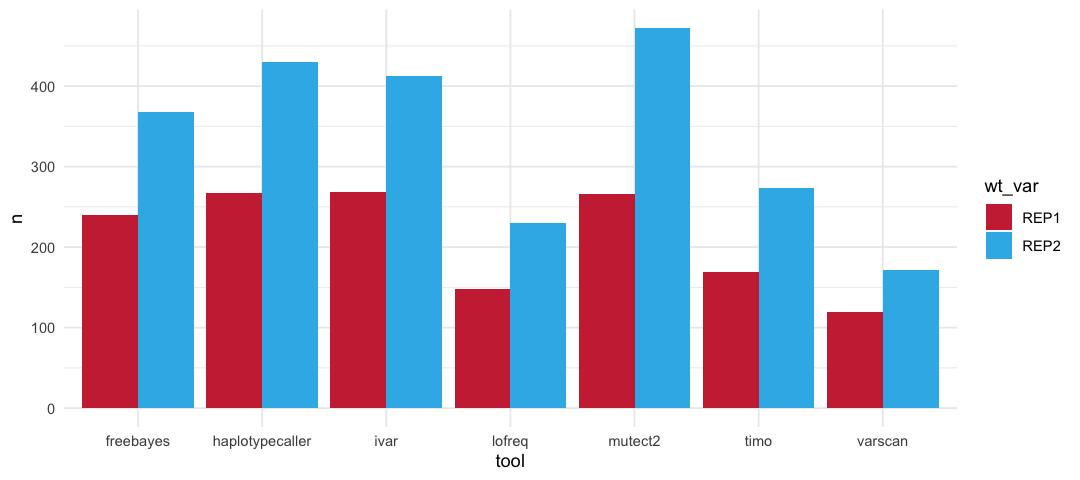

In [66]:
num_plot <- ggplot(nums, aes(x = tool, y = n, fill = wt_var)) +

    geom_col(position = 'dodge') +

    theme_minimal() +

    scale_fill_manual(values = tool_colors[c(1:6,8)]) 
             

print(num_plot)

In [67]:
ggsave(num_plot, filename = "mv.per.caller.pdf",
    path=output_folder, width = 3, height = 3, limitsize=FALSE, useDingbats =FALSE)

In [68]:
# Plot intersections of minority variants in rep1 between all callers
pdf(file = glue("{output_folder}/upset.minors.1.pdf"),   # The directory you want to save the file in
    width = 5, # The width of the plot in inches
    height = 4) # The height of the plot in inches

upset(fromList(min.list.1.high), 
      sets = names(min.list.1.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

dev.off()

pdf 
  2

In [69]:
# Plot intersections of minority variants in rep2 between all callers
pdf(file = glue("{output_folder}/upset.minors.2.pdf"),   # The directory you want to save the file in
    width = 5, # The width of the plot in inches
    height = 4) # The height of the plot in inches

upset(fromList(min.list.2.high), 
      sets = names(min.list.2.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

dev.off()

pdf 
  2

Mutect2 and haplotype caller identified many that other callers did not, particularly in replicate 2, and missed several variants identified by the other callers. None of the callers identified unique variants at these thresholds (Fig S11B)

### Fig. S8B

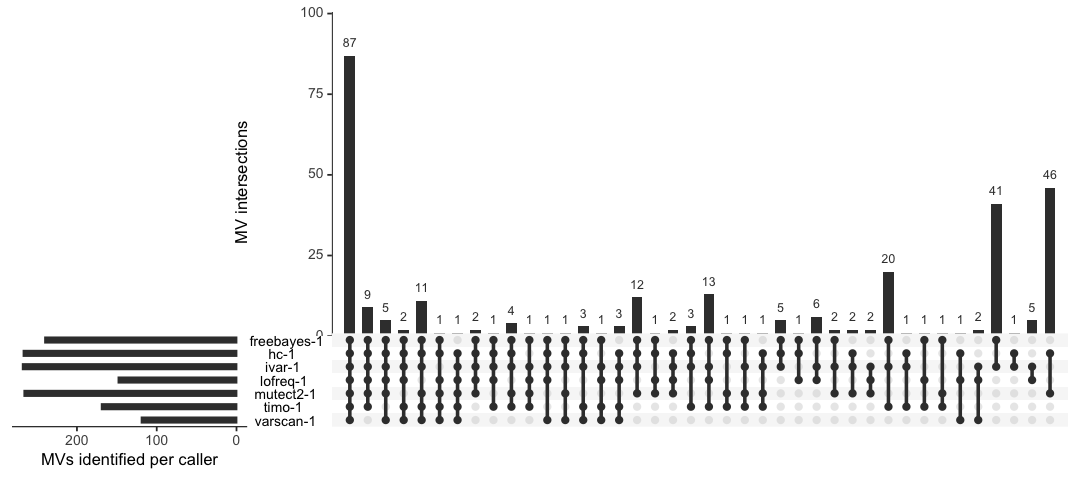

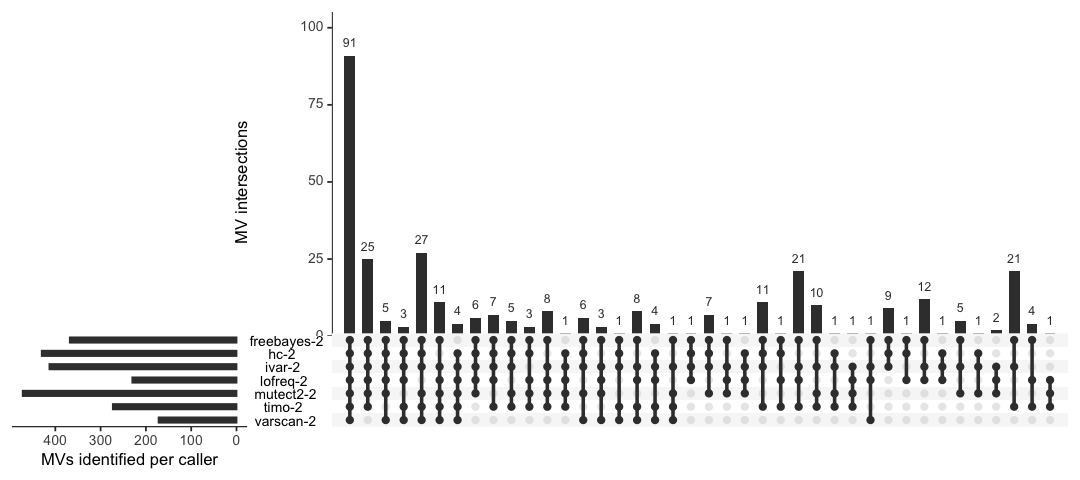

In [70]:
upset(fromList(min.list.1.high), 
      sets = names(min.list.1.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

upset(fromList(min.list.2.high), 
      sets = names(min.list.2.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

Given the high numbers of false positives identified by haplotype caller, mutect2 and lofreq in the simulated and synthetic datasets, we looked at the intersection of minority SNVs found in just the other four variant callers, freebayes, iVar, varscan, timo.

In [20]:
# remove lofreq, mutect2 and haplotype caller
min.list.1.high <- min.list.1.high[-3]
min.list.2.high <- min.list.2.high[-3]
min.list.1.high <- min.list.1.high[-3]
min.list.2.high <- min.list.2.high[-3]
min.list.1.high <- min.list.1.high[-4]
min.list.2.high <- min.list.2.high[-4]

In [22]:
# Plot intersections of minority variants in rep2 between all callers
pdf(file = glue("{output_folder}/upset.minors.1.filtered.pdf"),   # The directory you want to save the file in
    width = 5, # The width of the plot in inches
    height = 4) # The height of the plot in inches

upset(fromList(min.list.1.high), 
      sets = names(min.list.1.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

dev.off()

pdf 
  2

In [23]:
# Plot intersections of minority variants in rep2 between all callers
pdf(file = glue("{output_folder}/upset.minors.2.filtered.pdf"),   # The directory you want to save the file in
    width = 5, # The width of the plot in inches
    height = 4) # The height of the plot in inches

upset(fromList(min.list.2.high), 
      sets = names(min.list.2.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

dev.off()

pdf 
  2

Of all the minority variants found in the data, 104 from replicate 1, and 142 from replicate 2 were identified by all four of the variant callers, while another large set of variants were identified by freebayes, ivar and timo (Fig. 5B).

### Fig. 4B

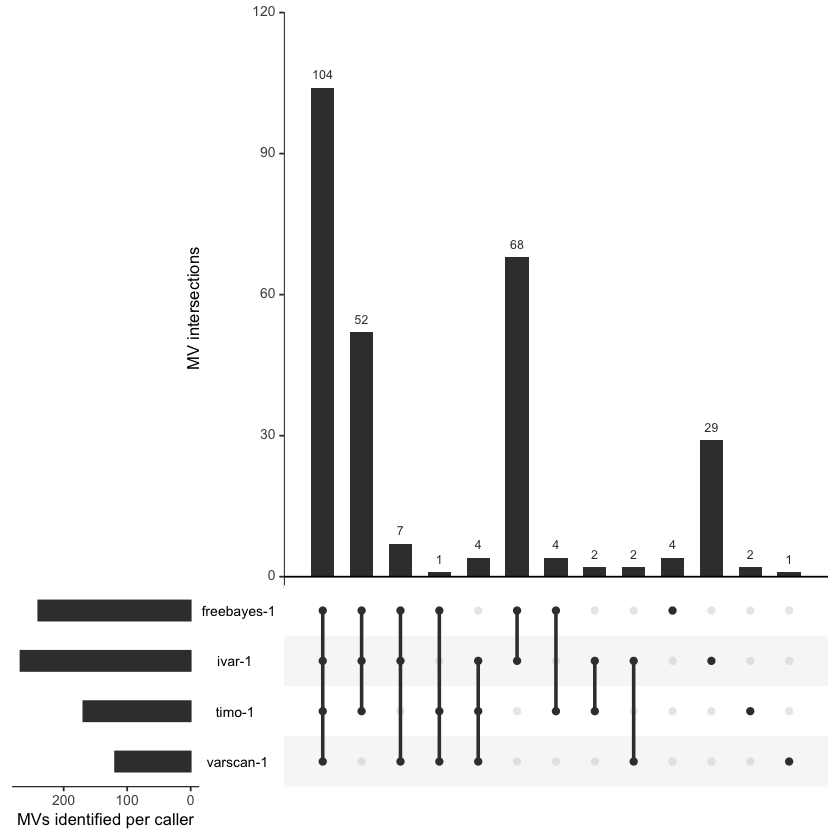

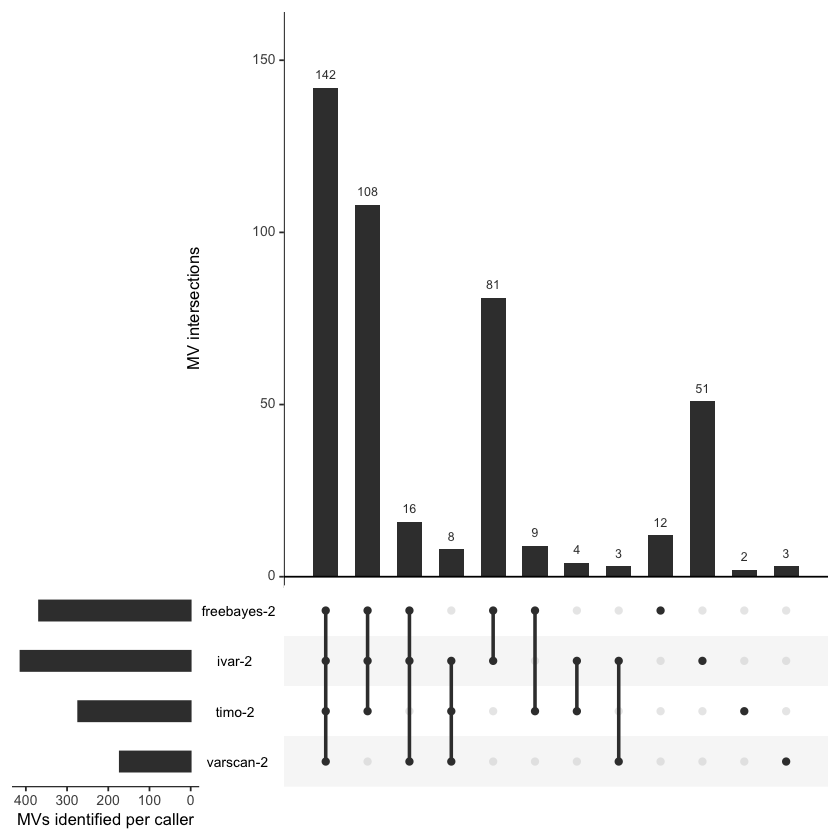

In [24]:
upset(fromList(min.list.1.high), 
      sets = names(min.list.1.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

upset(fromList(min.list.2.high), 
      sets = names(min.list.2.high), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

Overall, choice of variant caller appears to have a significant impact on the set of minority variants identified in clinical SARS-CoV-2 data.

Many studies of minority variants investigate frequency of minority variants to calculate selection, bottleneck size, and potential for transmission. Because of this, frequency of a variant is often considered to be just as important as presence/absence of the variant. We were interested in how well the variant callers agreed on the frequency at which variants were identified.

In [44]:
# separate minor variants identified by each tool to compare frequency called by each tool
timo.min <- min.changes.high %>% filter(tool == "timo") %>% select(-c(tool,change,rep.change,param))
names(timo.min)[names(timo.min) == 'varfreq'] <- "varfreq.timo"
names(timo.min)[names(timo.min) == 'totalcount'] <- "dp.timo"

ivar.min <- min.changes.high %>% filter(tool == "ivar") %>% select(-c(tool,change,rep.change,param))
names(ivar.min)[names(ivar.min) == 'varfreq'] <- "varfreq.ivar"
names(ivar.min)[names(ivar.min) == 'totalcount'] <- "dp.ivar"

fb.min <- min.changes.high %>% filter(tool == "freebayes") %>% select(-c(tool,change,rep.change,param))
names(fb.min)[names(fb.min) == 'varfreq'] <- "varfreq.fb"
names(fb.min)[names(fb.min) == 'totalcount'] <- "dp.fb"

hc.min <- min.changes.high %>% filter(tool == "haplotypecaller") %>% select(-c(tool,change,rep.change,param))
names(hc.min)[names(hc.min) == 'varfreq'] <- "varfreq.hc"
names(hc.min)[names(hc.min) == 'totalcount'] <- "dp.hc"

vs.min <- min.changes.high %>% filter(tool == "varscan") %>% select(-c(tool,change,rep.change,param))
names(vs.min)[names(vs.min) == 'varfreq'] <- "varfreq.vs"
names(vs.min)[names(vs.min) == 'totalcount'] <- "dp.vs"

lf.min <- min.changes.high %>% filter(tool == "lofreq") %>% select(-c(tool,change,rep.change,param))
names(lf.min)[names(lf.min) == 'varfreq'] <- "varfreq.lf"
names(lf.min)[names(lf.min) == 'totalcount'] <- "dp.lf"

In [45]:
# merge back into a single data frame
changes <- merge(timo.min, ivar.min, 
                 by=c("source_ID","ntpos","sample.change","refnt","varnt","rep"), 
                 all.x = T, all.y = T)
changes <- merge(changes, fb.min, 
                 by=c("source_ID","ntpos","sample.change","refnt","varnt","rep"), 
                 all.x = T, all.y = T)
changes <- merge(changes, hc.min, 
                 by=c("source_ID","ntpos","sample.change","refnt","varnt","rep"), 
                 all.x = T, all.y = T)
changes <- merge(changes, vs.min, 
                 by=c("source_ID","ntpos","sample.change","refnt","varnt","rep"), 
                 all.x = T, all.y = T)
changes <- merge(changes, lf.min, 
                 by=c("source_ID","ntpos","sample.change","refnt","varnt","rep"), 
                 all.x = T, all.y = T)

In [46]:
# set any N/A values to zero
changes[is.na(changes)] <- 0

To investigate this, we plotted the frequency of a variant in one caller against the frequency in each other caller (Fig. 6C). Minority variants identified by only one of the tools lie on the x or y axis, indicating a frequency of 0 in the other tool. Of particular interest, variants called by one caller but not another spanned a frequency range of 0.03 all the way to 0.5, indicating that even high frequency minority variants were often not agreed upon by variant callers.

In [55]:
# compare each set of callers
options(repr.plot.width=10, repr.plot.height=6)
plot5 = changes %>%
          ggplot(aes(x=varfreq.timo, y=varfreq.ivar,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "timo frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "ivar frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot6 = changes %>%
          ggplot(aes(x=varfreq.timo, y=varfreq.hc,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "timo frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "haplotype caller frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot7 = changes %>%
          ggplot(aes(x=varfreq.timo, y=varfreq.fb,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "timo frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "freebayes frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot8 = changes %>%
          ggplot(aes(x=varfreq.timo, y=varfreq.vs,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "timo frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "varscan frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot9 = changes %>%
          ggplot(aes(x=varfreq.timo, y=varfreq.lf,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "timo frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "lofreq frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot10 = changes %>%
          ggplot(aes(x=varfreq.ivar, y=varfreq.hc,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "ivar frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "haplotype caller frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot11 = changes %>%
          ggplot(aes(x=varfreq.ivar, y=varfreq.fb,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "ivar frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "freebayes frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot12 = changes %>%
          ggplot(aes(x=varfreq.ivar, y=varfreq.vs,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "ivar frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "varscan frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot13 = changes %>%
          ggplot(aes(x=varfreq.ivar, y=varfreq.lf,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "ivar frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "lofreq frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot14 = changes %>%
          ggplot(aes(x=varfreq.hc, y=varfreq.fb,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "haplotype caller frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "freebayes frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot15 = changes %>%
          ggplot(aes(x=varfreq.hc, y=varfreq.vs,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "haplotype caller frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "varscan frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot16 = changes %>%
          ggplot(aes(x=varfreq.hc, y=varfreq.lf,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "haplotype caller frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "lofreq frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot17 = changes %>%
          ggplot(aes(x=varfreq.fb, y=varfreq.vs,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "freebayes frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "varscan frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot18 = changes %>%
          ggplot(aes(x=varfreq.fb, y=varfreq.lf,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "freebayes frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "lofreq frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])
plot19 = changes %>%
          ggplot(aes(x=varfreq.vs, y=varfreq.lf,color=rep)) +
          geom_point(size=2, alpha=0.8, shape='square') +
          scale_x_continuous(name = "varscan frequency",
                             limits=c(0,0.5)) +
          scale_y_continuous(name = "lofreq frequency",
                            limits=c(0,0.5)) +
          theme_bw() +
          scale_color_manual(values = cat_colors[c(1,3)])

In [56]:
options(repr.plot.width=16, repr.plot.height=6)
allfreq <- ggarrange(plot5, plot6, plot7,plot8, plot9, 
          plot10,plot11, plot12, plot13, plot14,
          plot15, plot16, plot17, plot18, plot19,
          nrow = 3, ncol = 5)

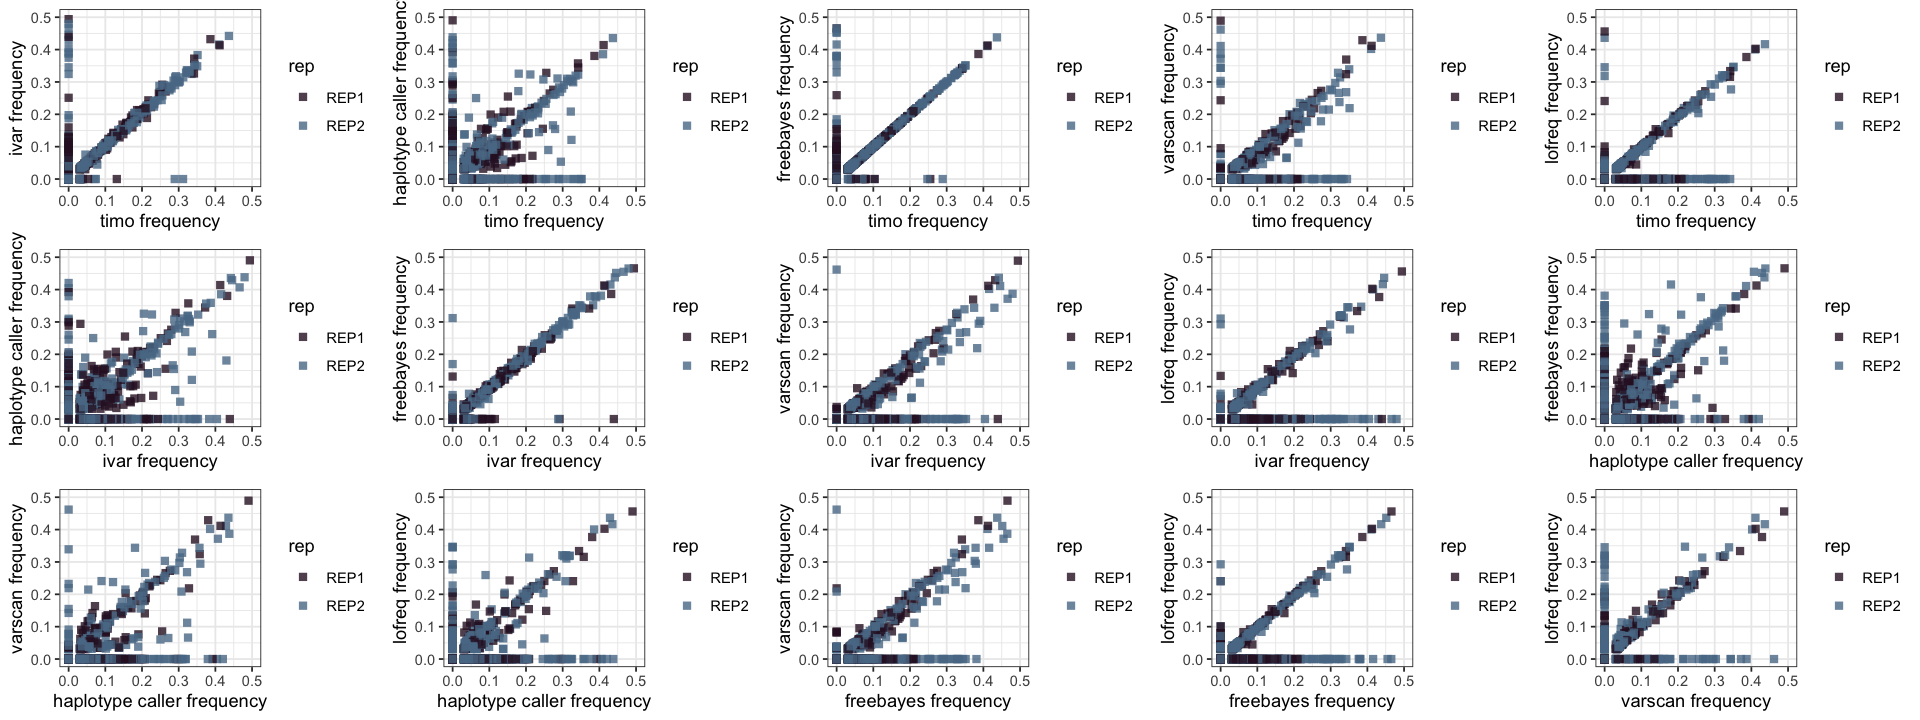

In [57]:
allfreq

In [58]:
# look at just the 4 variant callers that performed the best
options(repr.plot.width=9, repr.plot.height=4)
allfreq <- ggarrange(plot5,plot7,plot8, 
          plot11,plot12,plot17,
          nrow = 2, ncol = 3)

However, most of the minority variant callers were strikingly similar in their frequency calls of shared variants. Timo, freebayes and iVar all showed almost complete agreement on frequency of the variants. Varscan showed more variation in frequency, generally calling variants at a lower frequency than the other three tools, similar to what was observed in the synthetic data sets (Fig. 5C, S6B). 

### Fig. 4C

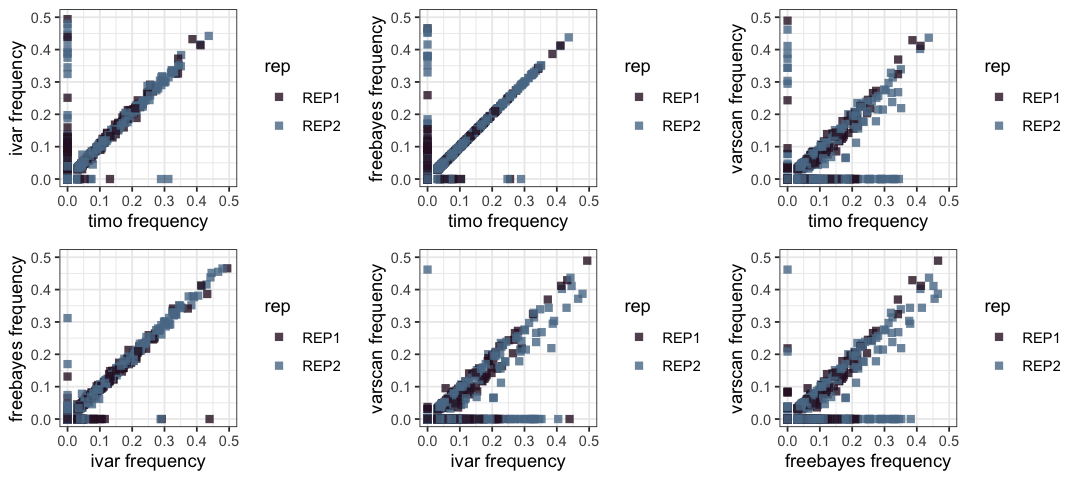

In [59]:
allfreq

In [60]:
ggsave(allfreq, filename = "caller.freqcompare.pdf",
    path=output_folder, width = 9, height = 4, limitsize=FALSE, useDingbats =FALSE)

These data show that choice of variant caller not only affects the set of the minority variants that are identified in a data set, but also the frequency of those variants.
